## Importing libraries and Environment Setup

In [ ]:
!pip install tensorflow

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 MB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import pickle
import joblib
import zipfile
import re
import glob

import sklearn.pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import xgboost as xgb
from xgboost import XGBClassifier

from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

### Participant ETL pipeline

''' We Fetch the pkl file which contains the sensor data for wrist watch, chest sensors and stress labels.

''' We also fwetch questonaire filled in by partcipant indicating fi they feel streesed, ammused etc.

''' Fetching their metadata such as age, gender, height wt ..

''' Finally We compile resample all our sensors ata frequency of 40Hz. and add in the metadata.


In [ ]:
def participant_pkl_data(subject_folder, subject):
    """
    takes: each participants data folder and subject tag

    returns: chest, wrist data and the labels for stress, no stress, amusement ...
    """
    with open(subject_folder+f"/{subject}.pkl", "rb") as f:
        obj = pickle.load(f, encoding="latin1")

    return obj['signal']['chest'], obj['signal']['wrist'], obj['label']

def participant_questionaire(subject_folder, subject):
    """
    takes: each participants data folder and subject tag

    returns: questionaire about stress filled in by the participant (used based on label availablity)
    """

    df = pd.read_csv(subject_folder+f"/{subject}_quest.csv")
    return df

def participant_info(subject_folder, subject):
    """
    takes: each participants data folder and subject tag

    returns: information such as age, gender, smoker, coffee drinker, atheletic etc
    """
    with open(subject_folder+f"/{subject}_readme.txt", "r") as file:
        data = file.readlines()

    parsed_data = {}

    patterns = {
        "Age": r"Age:\s*(\d+)",
        "Height": r"Height \(cm\):\s*(\d+)",
        "Weight": r"Weight \(kg\):\s*(\d+)",
        "Gender": r"Gender:\s*(\w+)",
        "Dominant Hand": r"Dominant hand:\s*(\w+)",
        "Drank Coffee Today": r"Did you drink coffee today\?\s*(\w+)",
        "Drank Coffee Last Hour": r"Did you drink coffee within the last hour\?\s*(\w+)",
        "Did Sports Today": r"Did you do any sports today\?\s*(\w+)",
        "Smoker": r"Are you a smoker\?\s*(\w+)",
        "Smoked Last Hour": r"Did you smoke within the last hour\?\s*(\w+)",
        "Feel Ill Today": r"Do you feel ill today\?\s*(\w+)"
    }

    for line in data:
        for key, pattern in patterns.items():
            match = re.search(pattern, line, re.IGNORECASE)
            if match:
                parsed_data[key] = match.group(1)

    return parsed_data

def resample_sensor_arrays(sensor_data, info, subject, target_freq = 40):
    frequencies = {'ACC': 32, 'BVP': 64, 'EDA': 4, 'TEMP': 4, 'labels': 700}

    # Estimate target length using a reference sensor (here: EDA)
    reference_sensor = 'EDA'
    if reference_sensor not in sensor_data:
        raise ValueError(f"Reference sensor '{reference_sensor}' missing.")

    original_len = len(sensor_data[reference_sensor])
    ref_freq = frequencies[reference_sensor]
    target_length = int(original_len * (target_freq / ref_freq))

    time_indices = np.arange(target_length) / target_freq  # Consistent timeline across all sensors
    print(f"\nProcessing: {subject}...\nTarget Frequency : {target_freq}Hz")

    resampled_data = {}

    for sensor, data in sensor_data.items():
        if sensor not in frequencies:  # Skip unknown sensors
            print(f"Skipping unknown sensor: {sensor}")
            continue

        sensor_freq = frequencies[sensor]
        sensor_time = np.arange(len(data)) / sensor_freq  # Correct time indices

        try:
            if sensor == "ACC":
                for i, axis in enumerate(["x", "y", "z"]):
                    # Accept both np.ndarray or nested list input
                    axis_data = data[:, i] if isinstance(data, np.ndarray) else np.array([row[i] for row in data])

                    # Handle NaNs using interpolation + fill
                    axis_data = pd.Series(axis_data).interpolate(limit_direction='both') \
                                                     .bfill().ffill()

                    interp_func = interp1d(sensor_time, axis_data, kind='slinear', fill_value="extrapolate")
                    resampled_data[f"ACC_{axis}"] = interp_func(time_indices)

            else:
                flat_data = np.array(data).flatten()
                flat_data = pd.Series(flat_data).interpolate(limit_direction='both') \
                                                .bfill().ffill()

                interp_func = interp1d(sensor_time, flat_data, kind='linear', fill_value="extrapolate")
                resampled_data[sensor] = interp_func(time_indices)

        except Exception as e:
            print(f"[ERROR] Sensor '{sensor}': {e}")

    for i, j in resampled_data.items():
        print(f"{i} : {len(j)}")
    print(f"{subject} Resampled\n")

    # ✅ Final DataFrame with interpolated sensor data
    resampled_df = pd.DataFrame(resampled_data, index=time_indices)
    resampled_df.index.name = "Time (s)"

    # ✅ Append metadata and subject info
    for key, val in info.items():
        resampled_df[key] = val
    resampled_df['Subject'] = subject

    return resampled_df


## Helper Variables, Environmens Setup and additional Reuseable Functionalities

In [ ]:
# Defineing helper variables
subject_data = {}

subjects_half1 = ['S2','S3','S4','S5','S6','S7','S8','S9']
subjects_half2= ['S10','S11','S13','S14','S15','S16','S17']
subjects = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S13','S14','S15','S16','S17']
WESAD_data_files_path = '/content/drive/Shareddrives/MediCap/Project_files/WESAD/data/WESAD/'
sensors = ["Time (s)","ACC_x", "ACC_y", "ACC_z", "BVP", "EDA", "TEMP"]
metadata = ["Age", "Height", "Weight", "Gender", "Dominant Hand", "Did Sports Today","Smoker","Smoked Last Hour","Feel Ill Today"]

build_subjects = ['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15']
eval_subjects = ['S16', 'S17']

In [ ]:
def add_combined_acc(df):
    df["ACC_magnitude"] = np.sqrt(df["ACC_x"]**2 + df["ACC_y"]**2 + df["ACC_z"]**2)
    return df

def plot_sensor_graph(df, features, time_col="Time (s)", group_col="Subject", label_col="labels"):
    label_colors = {
        0: '#DDDDDD',
        1: '#1f77b4',
        2: '#d62728',
        3: '#2ca02c',
        4: '#9467bd'
    }

    label_names = {
        0: "Neutral",
        1: "Baseline",
        2: "Stress",
        3: "Amusement",
        4: "Meditation"
    }

    subjects = df[group_col].unique()

    for subj in subjects:
        df_subj = add_combined_acc(df[df[group_col] == subj].sort_values(time_col))


        for feat in features:
            plt.figure(figsize=(12, 4))
            plt.plot(df_subj[time_col], df_subj[f"{feat}"], label=f"{feat} Sensor", color='blue', alpha=0.6)

            plt.axhline(y=df_subj[feat].median(), color='green', linestyle='--', label='Baseline')

            last_label = None
            start_time = None

            for i, row in df_subj.iterrows():
                current_label = row[label_col]
                current_time = row[time_col]
                if last_label is None:
                    last_label = current_label
                    start_time = current_time
                elif current_label != last_label:
                    plt.axvspan(start_time, current_time, color=label_colors.get(last_label, '#EEEEEE'), alpha=0.1)
                    start_time = current_time
                    last_label = current_label
            plt.axvspan(start_time, df_subj[time_col].iloc[-1], color=label_colors.get(last_label, '#EEEEEE'), alpha=0.1)

            patches = [mpatches.Patch(color=color, label=label_names[l]) for l, color in label_colors.items()]
            plt.legend(handles=patches + plt.gca().get_legend_handles_labels()[0], loc='upper right')
            plt.title(f"Subject {subj} - {feat} with Emotion Overlay")
            plt.xlabel("Time (s)")
            plt.ylabel(feat)

        plt.tight_layout()
        plt.show()

def data_subsetting(df, subjects):
    subset = df[df['Subject'].isin(subjects)]
    return subset


## Createing Dataframe using Pipeline


In [ ]:
for subject in subjects:
    subject_file_path = WESAD_data_files_path + subject
    _, wrist_dict, label = participant_pkl_data(subject_file_path, subject)
    info = participant_info(subject_file_path, subject)
    wrist_dict['labels'] = label

    subject_sensordata = resample_sensor_arrays(wrist_dict, info, subject)
    subject_sensordata.reset_index(inplace=True)
    subject_data[subject] = subject_sensordata

# subject_data
dataframe = pd.concat(list(subject_data.values()), axis=0, ignore_index=True)
dataframe


Processing: S2...
Target Frequency : 40Hz
ACC_x : 243160
ACC_y : 243160
ACC_z : 243160
BVP : 243160
EDA : 243160
TEMP : 243160
labels : 243160
S2 Resampled


Processing: S3...
Target Frequency : 40Hz
ACC_x : 259720
ACC_y : 259720
ACC_z : 259720
BVP : 259720
EDA : 259720
TEMP : 259720
labels : 259720
S3 Resampled


Processing: S4...
Target Frequency : 40Hz
ACC_x : 256920
ACC_y : 256920
ACC_z : 256920
BVP : 256920
EDA : 256920
TEMP : 256920
labels : 256920
S4 Resampled


Processing: S5...
Target Frequency : 40Hz
ACC_x : 250320
ACC_y : 250320
ACC_z : 250320
BVP : 250320
EDA : 250320
TEMP : 250320
labels : 250320
S5 Resampled


Processing: S6...
Target Frequency : 40Hz
ACC_x : 282840
ACC_y : 282840
ACC_z : 282840
BVP : 282840
EDA : 282840
TEMP : 282840
labels : 282840
S6 Resampled


Processing: S7...
Target Frequency : 40Hz
ACC_x : 209520
ACC_y : 209520
ACC_z : 209520
BVP : 209520
EDA : 209520
TEMP : 209520
labels : 209520
S7 Resampled


Processing: S8...
Target Frequency : 40Hz
ACC_x : 2

,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight,Gender,Dominant Hand,Drank Coffee Today,Drank Coffee Last Hour,Did Sports Today,Smoker,Smoked Last Hour,Feel Ill Today,Subject
0,0.000,62.0,-21.0,107.0,-59.370,1.138257,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
1,0.025,65.2,6.2,63.8,-48.008,1.136976,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
2,0.050,51.0,10.6,30.2,-30.694,1.135694,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
3,0.075,45.4,11.8,18.6,-10.822,1.134413,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
4,0.100,52.4,15.8,26.0,7.580,1.133132,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474715,5919.875,-43.0,-44.0,-54.0,0.950,0.782691,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474716,5919.900,-39.0,-43.2,-85.2,-0.576,0.782563,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474717,5919.925,-14.0,-48.4,-100.2,-2.328,0.782435,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474718,5919.950,-50.0,3.2,-12.2,-4.200,0.782307,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17


To save dataframe will have to run this. but not running this for now.

In [ ]:
dataframe.to_csv(WESAD_data_files_path+'Participants_Data_Combined.csv')

## Exploratory Data Analysis

In [ ]:
dataframe.describe()

,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels
count,3.474720e+06,3.474720e+06,3.474720e+06,3.474720e+06,3.474720e+06,3.474720e+06,3.474720e+06,3.474720e+06
mean,2.921031e+03,1.165482e+01,-2.275649e+00,1.770887e+01,1.927426e-03,1.801767e+00,3.259806e+01,1.334726e+00
std,1.717374e+03,4.408103e+01,2.812948e+01,2.971658e+01,6.505540e+01,2.343230e+00,1.498083e+00,1.628349e+00
min,0.000000e+00,-1.540000e+02,-1.280000e+02,-1.280000e+02,-1.744426e+03,1.974200e-02,2.897000e+01,0.000000e+00
25%,1.447794e+03,-3.580000e+01,-1.900000e+01,-2.400000e+00,-1.491200e+01,3.361977e-01,3.155000e+01,0.000000e+00
50%,2.895587e+03,2.600000e+01,-1.000000e+00,1.700000e+01,2.114000e+00,8.309252e-01,3.271000e+01,1.000000e+00
75%,4.343381e+03,5.100000e+01,1.200000e+01,4.340000e+01,1.619800e+01,2.396007e+00,3.368000e+01,2.000000e+00
max,7.070975e+03,1.780000e+02,1.270000e+02,1.734000e+02,1.759372e+03,1.592147e+01,3.597000e+01,7.000000e+00


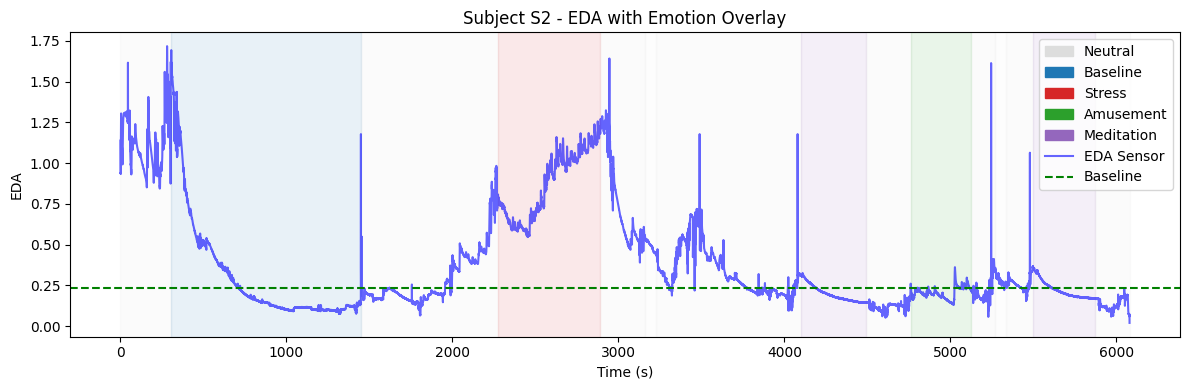

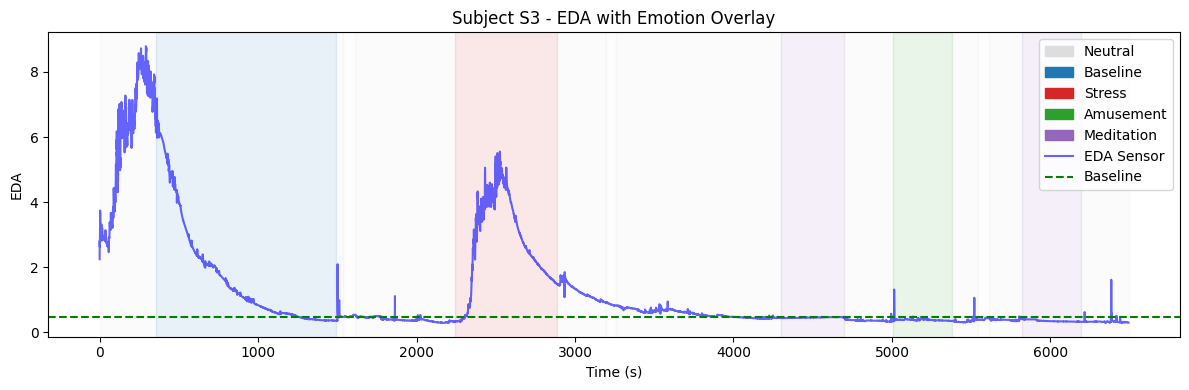

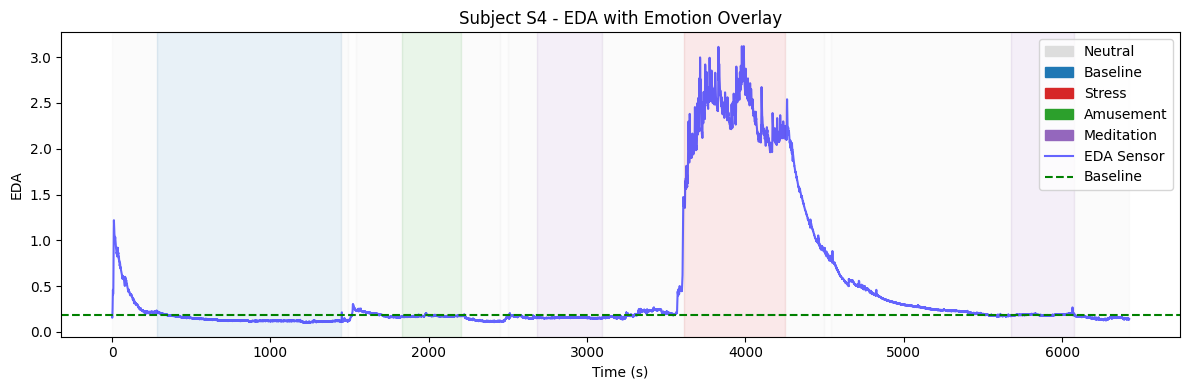

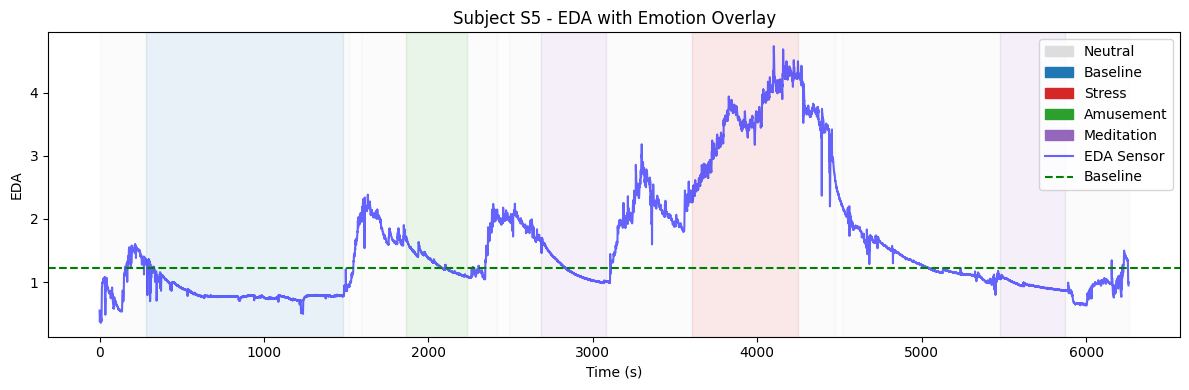

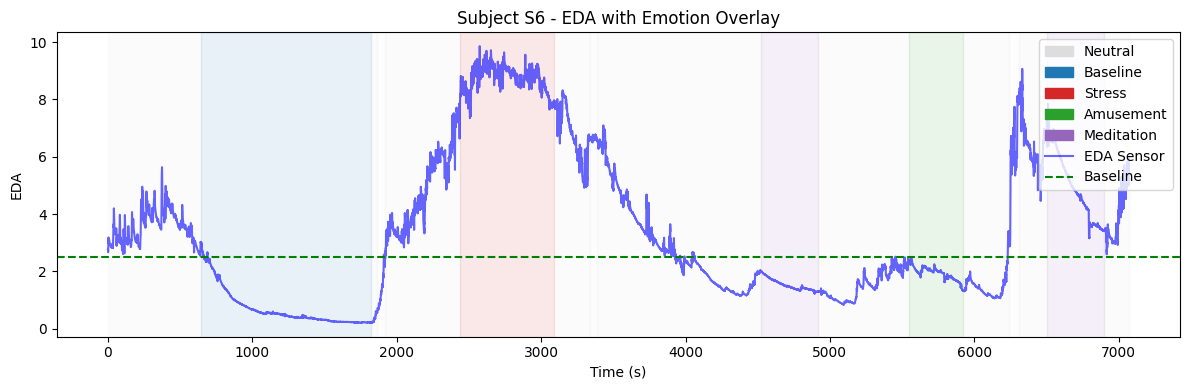

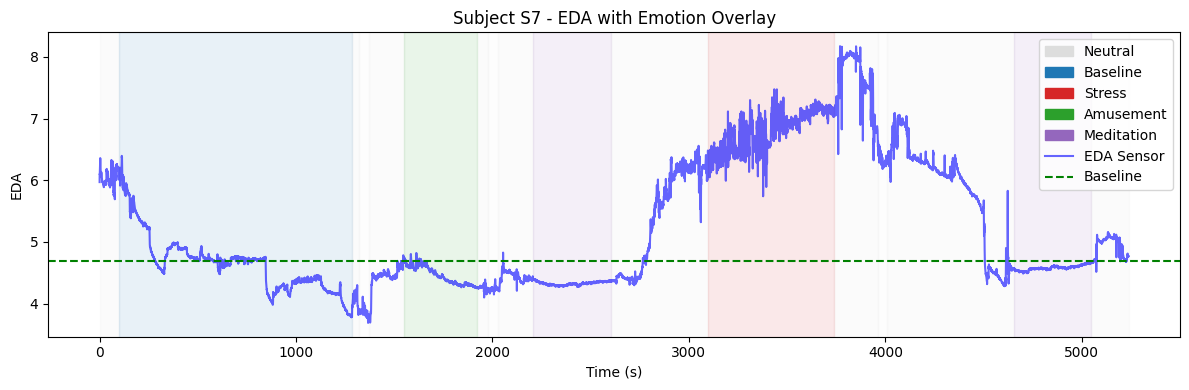

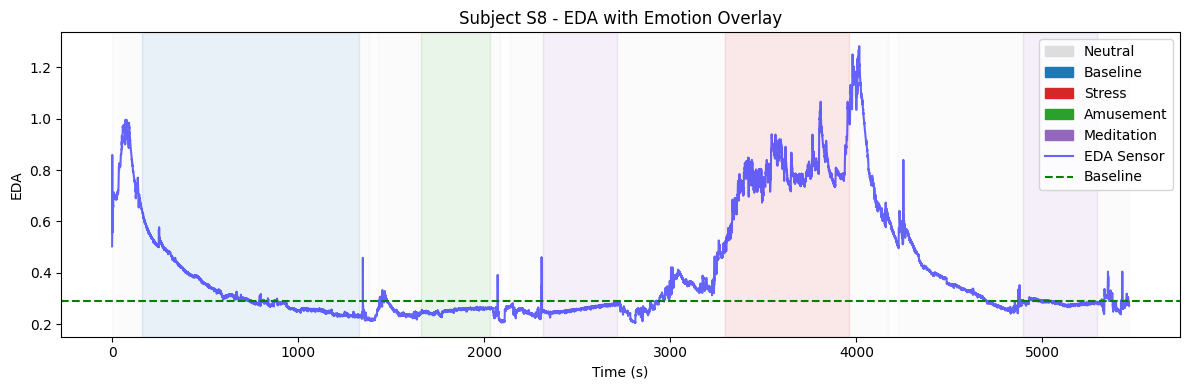

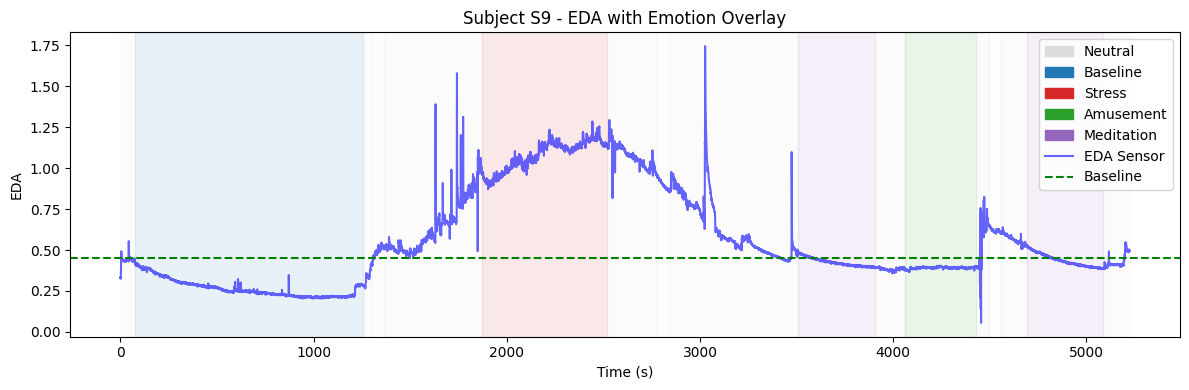

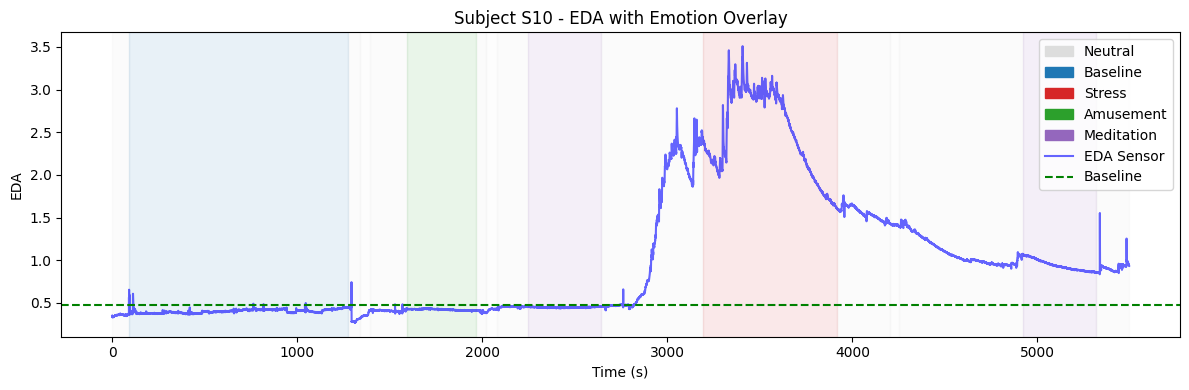

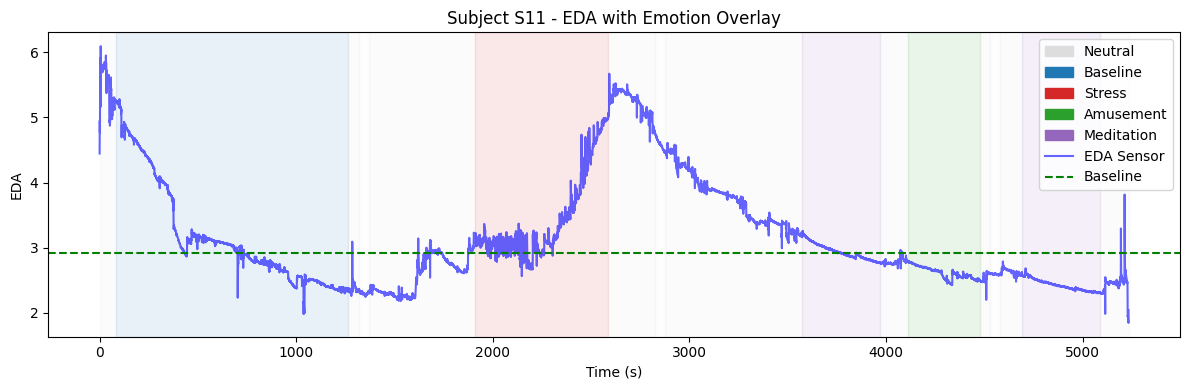

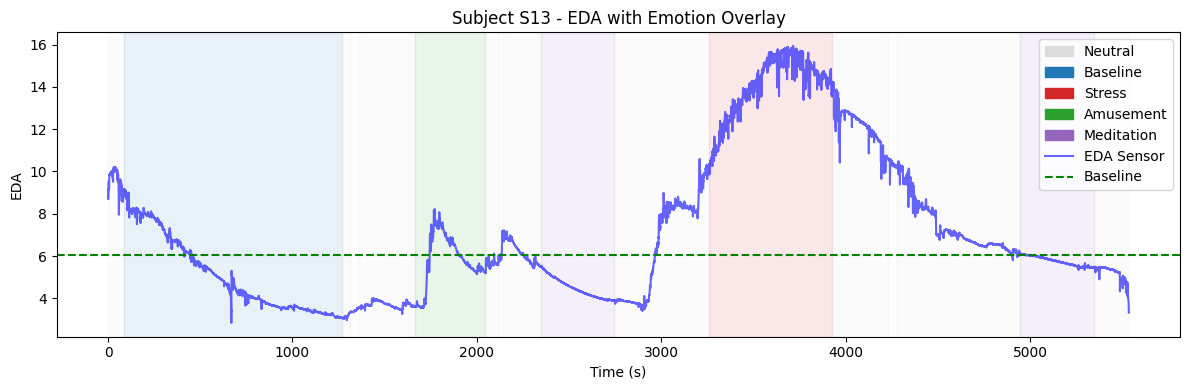

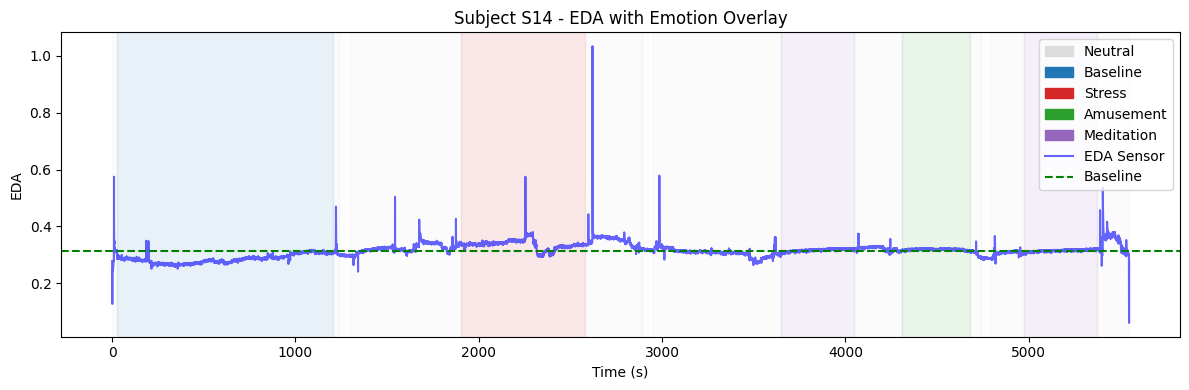

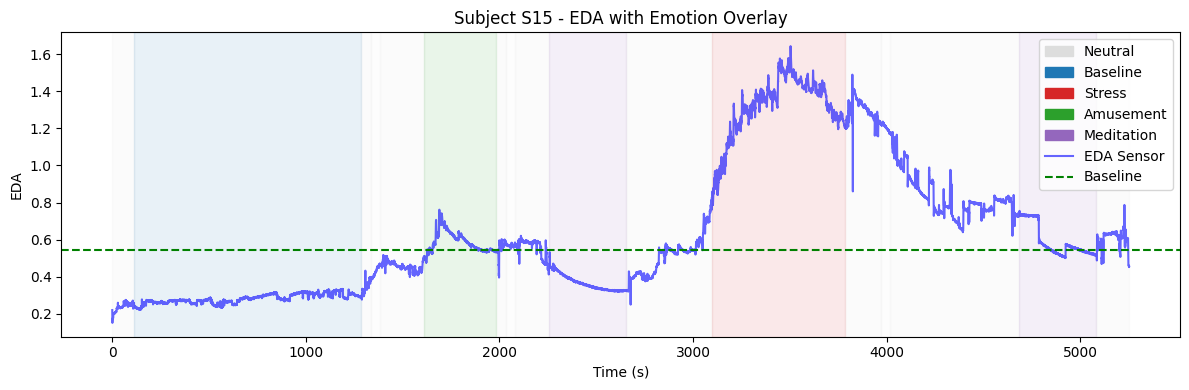

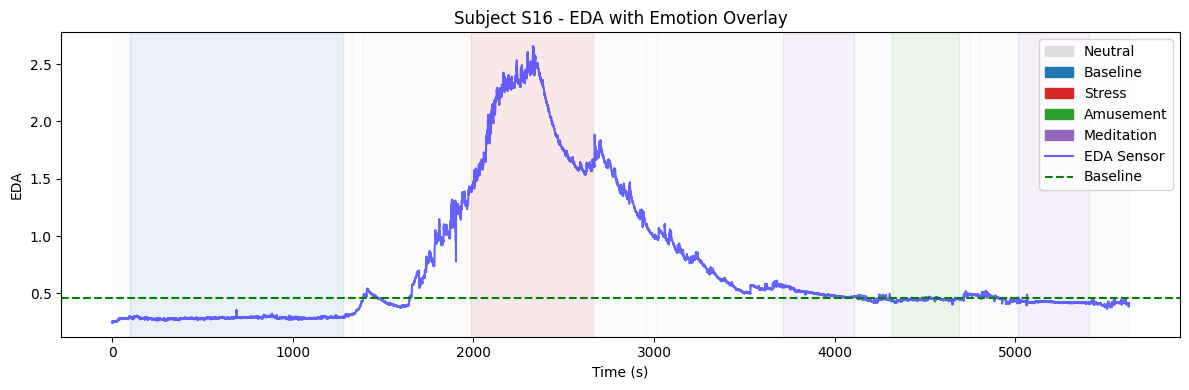

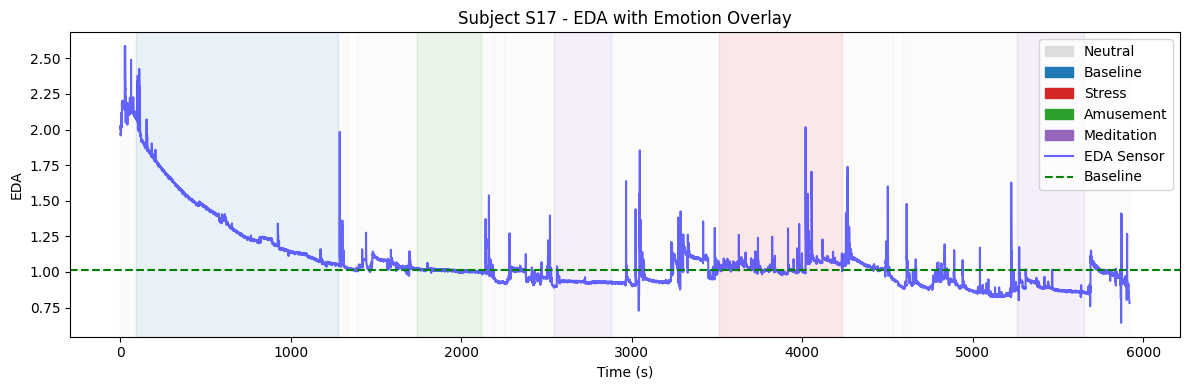

In [ ]:
plot_sensor_graph(dataframe, ['EDA'])

## Define Data short

In [ ]:
data = dataframe[dataframe['labels']<=3]
data

,Time (s),ACC_x,ACC_y,ACC_z,BVP,EDA,TEMP,labels,Age,Height,Weight,Gender,Dominant Hand,Drank Coffee Today,Drank Coffee Last Hour,Did Sports Today,Smoker,Smoked Last Hour,Feel Ill Today,Subject
0,0.000,62.0,-21.0,107.0,-59.370,1.138257,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
1,0.025,65.2,6.2,63.8,-48.008,1.136976,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
2,0.050,51.0,10.6,30.2,-30.694,1.135694,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
3,0.075,45.4,11.8,18.6,-10.822,1.134413,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
4,0.100,52.4,15.8,26.0,7.580,1.133132,35.41,0.0,27,175,80,male,right,NO,NO,NO,NO,NO,NO,S2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474715,5919.875,-43.0,-44.0,-54.0,0.950,0.782691,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474716,5919.900,-39.0,-43.2,-85.2,-0.576,0.782563,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474717,5919.925,-14.0,-48.4,-100.2,-2.328,0.782435,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17
3474718,5919.950,-50.0,3.2,-12.2,-4.200,0.782307,31.81,0.0,29,165,55,female,right,NO,NO,NO,NO,NO,NO,S17


## Model Building Pipeline Functions:
-- Preprocess_df : one-hot encoding and standard scaler

-- evaluate_model : Using Eval set to Evaluatethe classifier built

-- show_model_performance : Printer Function to display model performance on test and eval set

-- GetFeature_names : getting the features created post preprocessing

-- get_feature_importance : getting the top n features that impact the model

In [ ]:
def preprocess_df(df, preprocessor=None, target_column='labels'):
    """
    One‐hot encode categorical cols and scale numeric cols.
    If `preprocessor` is None, fits on df and returns it.
    Otherwise uses provided preprocessor to transform df.

    Returns:
        processed_df: pd.DataFrame with encoded+scaled features + target column
        preprocessor: fitted ColumnTransformer
    """
    df = df.copy()
    # Drop Subject if present
    df.drop(columns=['Subject'], errors='ignore', inplace=True)

    # Separate out target
    y = df[target_column]
    X = df.drop(columns=[target_column])

    # Identify columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Build transformer if needed
    if preprocessor is None:
        preprocessor = ColumnTransformer(transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', StandardScaler(), num_cols)
        ])
        X_trans = preprocessor.fit_transform(X)
    else:
        X_trans = preprocessor.transform(X)

    # Build DataFrame of transformed features
    # get_feature_names_out requires scikit-learn ≥1.0
    onehot_cols = (
        preprocessor.named_transformers_['cat']
                    .get_feature_names_out(cat_cols)
        if cat_cols else []
    )
    all_cols = list(onehot_cols) + num_cols
    X_df = pd.DataFrame(X_trans, columns=all_cols, index=df.index)

    # attach target
    X_df[target_column] = y.values
    return X_df, preprocessor

def evaluate_model_on_df(model, df, target_column='labels'):
    """
    Evaluates `model` on a separate df and returns the same metrics dict.
    """
    X = df.drop(columns=[target_column])
    y = df[target_column]


    # print(f"▶️ Evaluating Model on {df['Subject'].unique()}...")
    y_pred = model.predict(X)

    acc = accuracy_score(y, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y, y_pred, average='weighted', zero_division=0
    )
    per_cls = precision_recall_fscore_support(
        y, y_pred, average=None, zero_division=0, labels=np.unique(y)
    )

    metrics = {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'per_class': per_cls
    }
    print(f"▶️Evaluation Metrics Fetched")

    return metrics, y, y_pred

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix with annotations"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_results_table(results):
    """Display results in a formatted table"""
    display(HTML(
        pd.DataFrame(results)
        .style.set_properties(**{'text-align': 'center'})
        .set_table_styles([{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }])
        .hide(axis='index')
        .to_html()
    ))

def _get_feature_names(preprocessor):
    """
    Recover the output feature names from a fitted ColumnTransformer
    that does OneHotEncoder + StandardScaler in two blocks.
    """
    # 1) categorical feature names
    cat_name, cat_trans, cat_cols = preprocessor.transformers_[0]
    if hasattr(cat_trans, 'get_feature_names_out'):
        cat_features = cat_trans.get_feature_names_out(cat_cols)
    else:
        # fallback
        cat_features = cat_trans.get_feature_names(cat_cols)

    # 2) numeric feature names
    _, num_trans, num_cols = preprocessor.transformers_[1]
    num_features = list(num_cols)

    return list(cat_features) + num_features

def get_feature_importance(model, preprocessor, top_n=None):
    """
    Returns a DataFrame of feature importances sorted descending.

    Parameters:
      - model: trained RandomForestClassifier (or any with .feature_importances_)
      - preprocessor: fitted ColumnTransformer used before model.fit()
      - top_n: if provided, only returns the top_n features

    Returns:
      DataFrame with columns ['feature', 'importance'], sorted descending.
    """
    feature_names = _get_feature_names(preprocessor)
    importances   = model.feature_importances_

    fi_df = (
        pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        .sort_values('Importance', ascending=False)
        .reset_index(drop=True)
    )

    if top_n:
        return fi_df.head(top_n)
    return fi_df

## Random Forest Baseline Model

In [ ]:
#1. Random Forest Model Baseline Function
def train_random_forest_on_df(df, target_column='labels', test_size=0.2, random_state=42):
    """
    Splits df into 80/20, trains RandomForest, and returns:
      - model
      - train_metrics, test_metrics  (dicts with accuracy, precision, recall, f1, per_class)
    """
    # Split features/target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # Train
    print('Building RF Classifier Model...')
    model = RandomForestClassifier(random_state=random_state)
    model.fit(X_train, y_train)

    def _metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted'
        )
        per_cls = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=np.unique(y_true)
        )
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'per_class': per_cls
        }

    train_metrics = _metrics(y_train, model.predict(X_train))
    test_metrics  = _metrics(y_test,  model.predict(X_test))

    print("▶️ Training Complete")
    print("▶️ Testing Model...")
    print("Model, Training & Prediction metrics Fetched!")

    return model, train_metrics, test_metrics

In [ ]:
# 2. Subset based on your function (assuming it filters by df['Subject'])
buildset = data_subsetting(data, build_subjects)
evalset = data_subsetting(data, eval_subjects)

# 3. Preprocess train, test, eval dfs using same pipeline.
df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _ = preprocess_df(evalset, preprocessor=preprocessor)

# 3. Train & test on df1_proc
model, train_m, test_m = train_random_forest_on_df(df1_proc)

# 4. Finally evaluate on df2_proc
eval_m, y_eval, y_pred = evaluate_model_on_df(model, df2_proc)

Building RF Classifier Model...
▶️ Training Complete
▶️ Testing Model...
Model, Training & Prediction metrics Fetched!
▶️Evaluation Metrics Fetched


In [ ]:
print_results_table(test_m)

accuracy,precision,recall,f1,per_class
0.999962,0.999962,0.999962,0.999962,[0.99996722 0.99995082 0.99995624 0.99997415]
0.999962,0.999962,0.999962,0.999962,[0.99996357 0.9999918 0.9998979 0.99997415]
0.999962,0.999962,0.999962,0.999962,[0.99996539 0.99997131 0.99992707 0.99997415]
0.999962,0.999962,0.999962,0.999962,[274520 122000 68560 38680]


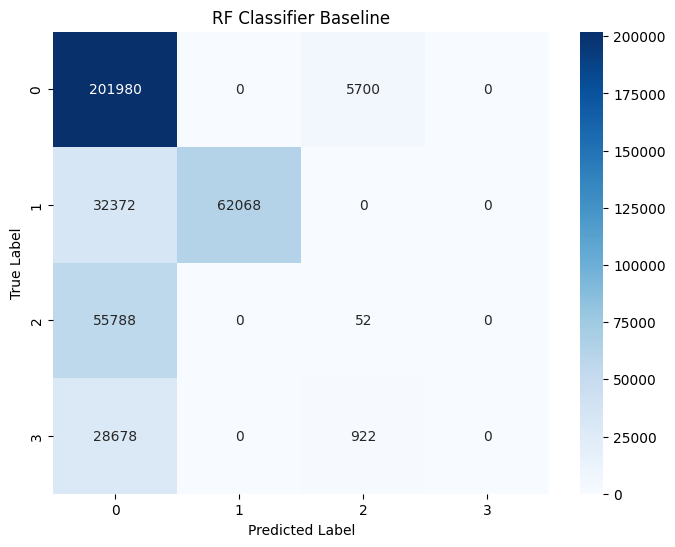

In [ ]:
plot_confusion_matrix(y_eval, y_pred, 'RF Classifier Baseline')

In [ ]:
# # Get all importances, sorted
# fi_top10 = get_feature_importance(model, preprocessor, top_n=10)
# fi_top10

## XG Boost Baseline

In [ ]:
def train_xgboost_on_df(df, target_column='labels',
                        test_size=0.2, random_state=42):
    """
    Splits df into 80/20, trains XGBClassifier, and returns:
      - model
      - train_metrics, test_metrics  (dicts with accuracy, precision, recall, f1, per_class)
    """
    # 1️⃣ Split features/target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # 2️⃣ Train XGBoost
    model = XGBClassifier(
        random_state=random_state,
        use_label_encoder=False,    # suppress warning
        eval_metric='mlogloss'      # multiclass logloss
    )
    model.fit(X_train, y_train)

    # 3️⃣ Metrics helper
    def _metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='weighted'
        )
        per_cls = precision_recall_fscore_support(
            y_true, y_pred, average=None, labels=np.unique(y_true)
        )
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'per_class': per_cls
        }

    train_metrics = _metrics(y_train, model.predict(X_train))
    test_metrics  = _metrics(y_test,  model.predict(X_test))

    print("▶️ XGB Training Metrics:", train_metrics)
    print("▶️ XGB Testing Metrics: ", test_metrics)

    return model, train_metrics, test_metrics


In [ ]:
# 1. Subset & preprocess exactly as before
buildset = data_subsetting(data, build_subjects)
evalset  = data_subsetting(data, eval_subjects)

df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _            = preprocess_df(evalset, preprocessor=preprocessor)

# 2. Train/test with XGBoost
xgb_model, xgb_train_m, xgb_test_m = train_xgboost_on_df(df1_proc)

# 3. Finally evaluate held-out subjects
xgb_eval_m, xg_y_eval, xg_y_pred = evaluate_model_on_df(xgb_model, df2_proc)

▶️ XGB Training Metrics: {'accuracy': 0.9985206249007463, 'precision': 0.9985208806789957, 'recall': 0.9985206249007463, 'f1': 0.998520705902394, 'per_class': (array([0.99882298, 0.99920111, 0.99782357, 0.99546731]), array([0.99846186, 0.99956762, 0.9980528 , 0.99646458]), array([0.99864239, 0.99938433, 0.99793817, 0.9959657 ]), array([1098080,  488000,  274240,  154720]))}
▶️ XGB Testing Metrics:  {'accuracy': 0.9983305542321741, 'precision': 0.9983310597287883, 'recall': 0.9983305542321741, 'f1': 0.998330703260681, 'per_class': (array([0.99872439, 0.99901682, 0.99741922, 0.99499277]), array([0.99821142, 0.99945082, 0.99776838, 0.99663909]), array([0.99846784, 0.99923377, 0.99759377, 0.99581525]), array([274520, 122000,  68560,  38680]))}
▶️Evaluation Metrics Fetched


In [ ]:
print_results_table(xgb_test_m)

accuracy,precision,recall,f1,per_class
0.998331,0.998331,0.998331,0.998331,[0.99872439 0.99901682 0.99741922 0.99499277]
0.998331,0.998331,0.998331,0.998331,[0.99821142 0.99945082 0.99776838 0.99663909]
0.998331,0.998331,0.998331,0.998331,[0.99846784 0.99923377 0.99759377 0.99581525]
0.998331,0.998331,0.998331,0.998331,[274520 122000 68560 38680]


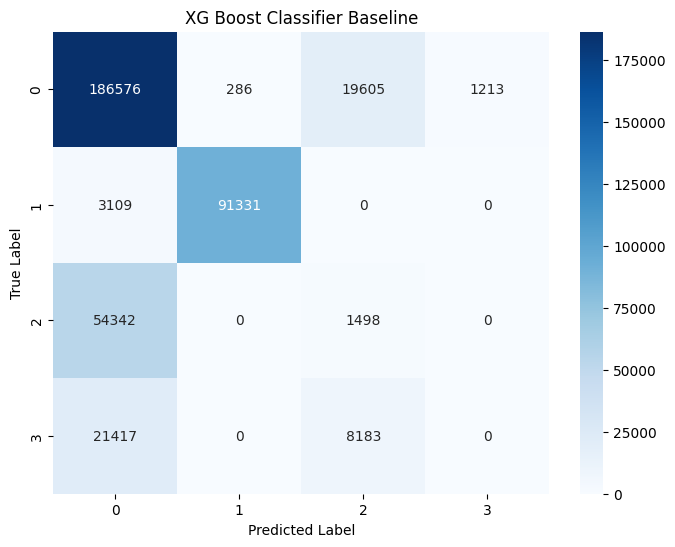

In [ ]:
plot_confusion_matrix(xg_y_eval, xg_y_pred, 'XG Boost Classifier Baseline')

In [ ]:
# fi_xgb = get_feature_importance(xgb_model, preprocessor, top_n=10)
# fi_xgb

## LSTM BiDi CNN

In [ ]:
def create_sequences(df, target_column='labels', window_size=100, step=20):
    """
    Turn a time-series DataFrame into (n_samples, window_size, n_features) for X
    and a label per window for y (using the label at the end of the window).
    """
    X = df.drop(columns=[target_column]).values
    y = df[target_column].values
    seqs, labels = [], []
    for start in range(0, len(X) - window_size, step):
        end = start + window_size
        seqs.append(X[start:end])
        labels.append(y[end-1])
    return np.array(seqs), np.array(labels)

In [ ]:
def build_attention_lstm_model(input_shape, num_classes):
    """LSTM with attention mechanism"""
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32)
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.3)(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(128)(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)

    x = tf.keras.layers.Multiply()([x, attention])
    x = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy'
    )
    return model

def build_lstm_model(input_shape, num_classes):
    m = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    m.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam'    )
    return m

def build_cnn_lstm_model(input_shape, num_classes):
    m = Sequential([
        Input(shape=input_shape),             # ← Declare your input here
        Conv1D(64, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        LSTM(64),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    m.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam'    )
    return m

In [ ]:
def train_and_eval_keras(df, build_model_fn,
                         window_size=40, step=20,
                         test_size=0.2, random_state=42,
                         epochs=20, batch_size=64):
    # 1. Create sequences
    X, y = create_sequences(df, window_size=window_size, step=step)
    # 2. Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    # 3. Build model
    num_classes = len(np.unique(y))
    model = build_model_fn(input_shape=X_tr.shape[1:], num_classes=num_classes)
    # 4. Train
    es = EarlyStopping(patience=3, restore_best_weights=True)
    model.fit(
        X_tr, y_tr,
        validation_split=0.1,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=2
    )
    # 5. Evaluate
    y_pred = model.predict(X_te).argmax(axis=1)
    print(classification_report(y_te, y_pred))
    return model

In [ ]:
# suppose df1_proc is your preprocessed DataFrame for S2–S15
buildset = data_subsetting(data, build_subjects)
evalset = data_subsetting(data, eval_subjects)

# 3. Preprocess train, test, eval dfs using same pipeline.
df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _ = preprocess_df(evalset, preprocessor=preprocessor)

In [ ]:
lstm_model = train_and_eval_keras(df1_proc, build_lstm_model)
cnn_lstm_model = train_and_eval_keras(df1_proc, build_cnn_lstm_model)
bi_lstm_model = train_and_eval_keras(df1_proc, build_attention_lstm_model)

Epoch 1/20
1417/1417 - 28s - 20ms/step - loss: 0.3402 - val_loss: 0.1697
Epoch 2/20
1417/1417 - 26s - 19ms/step - loss: 0.1815 - val_loss: 0.1352
Epoch 3/20
1417/1417 - 26s - 19ms/step - loss: 0.1418 - val_loss: 0.1324
Epoch 4/20
1417/1417 - 27s - 19ms/step - loss: 0.1225 - val_loss: 0.1063
Epoch 5/20
1417/1417 - 27s - 19ms/step - loss: 0.1093 - val_loss: 0.1024
Epoch 6/20
1417/1417 - 27s - 19ms/step - loss: 0.1043 - val_loss: 0.0859
Epoch 7/20
1417/1417 - 26s - 18ms/step - loss: 0.0942 - val_loss: 0.0729
Epoch 8/20
1417/1417 - 27s - 19ms/step - loss: 0.0890 - val_loss: 0.0856
Epoch 9/20
1417/1417 - 27s - 19ms/step - loss: 0.0822 - val_loss: 0.0703
Epoch 10/20
1417/1417 - 27s - 19ms/step - loss: 0.0781 - val_loss: 0.0699
Epoch 11/20
1417/1417 - 27s - 19ms/step - loss: 0.0764 - val_loss: 0.0761
Epoch 12/20
1417/1417 - 27s - 19ms/step - loss: 0.0714 - val_loss: 0.0687
Epoch 13/20
1417/1417 - 26s - 19ms/step - loss: 0.0711 - val_loss: 0.0710
Epoch 14/20
1417/1417 - 26s - 19ms/step - loss:

In [ ]:
# create sequences for df2_proc
X_eval, y_eval = create_sequences(df2_proc, window_size=40, step=20)
y_pred = lstm_model.predict(X_eval).argmax(axis=1)
print("LSTM on Eval:\n", classification_report(y_eval, y_pred))

y_pred = cnn_lstm_model.predict(X_eval).argmax(axis=1)
print("CNN-LSTM on Eval:\n", classification_report(y_eval, y_pred))


## Feature Engineering Pipeline

In [ ]:
def feature_set(feat):
    return [feat, f"{feat}_baseline", f"{feat}_mean", f"{feat}_std", f"{feat}_max", f"{feat}_min", f"{feat}_roc"]

def add_rolling_features(df, features, group_col="Subject"):
    df = df.sort_values([group_col, "Time (s)"])

    for feature in features:
        df[f"{feature}_baseline"] = df.groupby(group_col)[feature].transform("median")
        df[f"{feature}_mean"] = df.groupby(group_col)[feature].transform(lambda x: x.rolling(window=200, min_periods=1).mean())
        df[f"{feature}_std"] = df.groupby(group_col)[feature].transform(lambda x: x.rolling(window=200, min_periods=1).std())
        df[f'{feature}_max'] = df.groupby(group_col)[feature].transform(lambda x: x.rolling(window=200, min_periods=1).max()).astype(np.float32)
        df[f'{feature}_min'] = df.groupby(group_col)[feature].transform(lambda x: x.rolling(window=200, min_periods=1).min()).astype(np.float32)
        df[f'{feature}_max'] = df.groupby(group_col)[feature].transform(lambda x: x.rolling(window=200, min_periods=1).max()).astype(np.float32)
        df[f'{feature}_roc'] = df.groupby(group_col)[feature].transform(lambda x: x.pct_change().fillna(0).clip(-1, 1)).astype(np.float32)

    return df

In [ ]:
# data = add_rolling_features(dataframe, ['EDA'])
# plot_sensor_graph(data, feature_set('EDA'))

In [ ]:

# Main Pipeline


# 1. Data Preparation
print("Preparing data...")
buildset = data_subsetting(data, build_subjects)
evalset = data_subsetting(data, eval_subjects)
df1_proc, preprocessor = preprocess_df(buildset)
df2_proc, _ = preprocess_df(evalset, preprocessor=preprocessor)

# Binary label mapping (0: non-stress, 1: stress)
binary_map = {0:0, 1:0, 2:1, 3:0}
df1_binary = df1_proc.copy()
df1_binary['labels'] = df1_binary['labels'].map(binary_map)
df2_binary = df2_proc.copy()
df2_binary['labels'] = df2_binary['labels'].map(binary_map)


# Evaluation functions

def run_model_evaluation(model_func, train_df, test_df, model_name, mode):
    """Generic evaluation using original training functions"""
    # Train model
    if model_func.__name__ in ['train_random_forest_on_df', 'train_xgboost_on_df']:
        model, _, _ = model_func(train_df)
        X_test = test_df.drop(columns=['labels'])
        y_test = test_df['labels']
        y_pred = model.predict(X_test)
    else:  # LSTM models
        model = train_and_eval_keras(train_df, model_func)
        X_test, y_test = create_sequences(test_df)
        y_pred = model.predict(X_test).argmax(axis=1)

    # Generate reports
    print(f"\n\n{'='*80}")
    print(f"{model_name} - {mode} Evaluation")
    print(f"{'='*80}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    print("\nConfusion Matrix:")
    plt.figure(figsize=(8,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - {mode}')
    plt.show()


# Model Evaluations


# 1. Random Forest
run_model_evaluation(train_random_forest_on_df, df1_proc, df2_proc, "Random Forest", "Multi-class")
run_model_evaluation(train_random_forest_on_df, df1_binary, df2_binary, "Random Forest", "Binary")

# 2. XGBoost
run_model_evaluation(train_xgboost_on_df, df1_proc, df2_proc, "XGBoost", "Multi-class")
run_model_evaluation(train_xgboost_on_df, df1_binary, df2_binary, "XGBoost", "Binary")

# 3. LSTM
run_model_evaluation(build_lstm_model, df1_proc, df2_proc, "LSTM", "Multi-class")
run_model_evaluation(build_lstm_model, df1_binary, df2_binary, "LSTM", "Binary")

# 4. CNN-LSTM
run_model_evaluation(build_cnn_lstm_model, df1_proc, df2_proc, "CNN-LSTM", "Multi-class")
run_model_evaluation(build_cnn_lstm_model, df1_binary, df2_binary, "CNN-LSTM", "Binary")

# 5. Attention LSTM
run_model_evaluation(build_attention_lstm_model, df1_proc, df2_proc, "Attention LSTM", "Multi-class")
run_model_evaluation(build_attention_lstm_model, df1_binary, df2_binary, "Attention LSTM", "Binary")

print("\n\nEVALUATION COMPLETE FOR ALL MODELS")